In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures


# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
# Read in data.
df = pd.read_csv('../data/redditstartupproject.csv')

# Check out first five rows.
df.head()

,title,score,id,url,comms_num,created,body,subreddit
0,Paying 3rd party creators.,1,jeg3p2,https://www.reddit.com/r/startups/comments/jeg...,0,1.603188e+09,I’m creating an e-commerce site (most likely w...,1
1,I'm hosting a free Etsy event on Eventbrite!,0,jeftmx,https://www.reddit.com/r/startups/comments/jef...,0,1.603187e+09,Come for an information/Q&A event on Wednesday...,1
2,Leveraging old technology owned by someone els...,1,jef9o4,https://www.reddit.com/r/startups/comments/jef...,2,1.603185e+09,Hi community friends - I have a question and I...,1
3,Looking for resource to make a classifieds sty...,0,jee9u0,https://www.reddit.com/r/startups/comments/jee...,0,1.603181e+09,Ideally something simple like Squarespace. May...,1
4,What health insurance does your startup use?,1,jeduys,https://www.reddit.com/r/startups/comments/jed...,6,1.603180e+09,"Hey guys, we recently raised an institutional ...",1


In [3]:
df = df[['title', 'subreddit']]

In [4]:
df.shape

(1891, 2)

In [7]:
X = df['title']
y = df['subreddit']

In [8]:
y.value_counts(normalize=True)

0    0.524061
1    0.475939
Name: subreddit, dtype: float64

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

In [10]:
# Instantiate a CountVectorizer.
cvec = CountVectorizer()

In [11]:
# Fit the vectorizer on our corpus.
cvec.fit(X_train)

CountVectorizer()

In [12]:
# Transform the corpus.
X_train_cv = cvec.transform(X_train)

In [13]:
X_test_cv = cvec.transform(X_test)

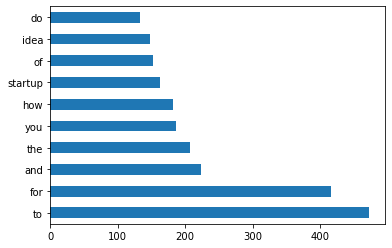

In [14]:
# Convert X_train into a DataFrame.
# We will not actually use this for modeling,
# this is just to visualize what is happening
# gives the count of each words
X_train_df = pd.DataFrame(X_train_cv.todense(), 
                          columns=cvec.get_feature_names())

X_test_df = pd.DataFrame(X_test_cv.todense(), 
                          columns=cvec.get_feature_names())

# plot top occuring words
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh'); # all stop words

In [15]:
y_test.value_counts(normalize=True)

0    0.525066
1    0.474934
Name: subreddit, dtype: float64

In [16]:
y_train.value_counts(normalize=True)

0    0.52381
1    0.47619
Name: subreddit, dtype: float64

# Logistic Regression

In [17]:
lr = LogisticRegression()

In [19]:
lr.fit(X_train_df, y_train)

LogisticRegression()

In [21]:
lr.score(X_train_df, y_train), lr.score(X_test_df, y_test)  # overfit

(0.9675925925925926, 0.7730870712401056)

# Logistic Regression  - with stop word

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

In [26]:
# Instantiate a CountVectorizer.
cvst = CountVectorizer(stop_words = 'english')

# Fit the vectorizer on our corpus.
cvst.fit(X_train)

# Transform the corpus.
X_train_cvst = cvst.transform(X_train)
X_test_cvst = cvst.transform(X_test)

In [27]:
lr = LogisticRegression()
lr.fit(X_train_cvst, y_train)
lr.score(X_train_cvst, y_train), lr.score(X_test_cvst, y_test)

(0.9609788359788359, 0.7493403693931399)

# Logistic Regression - with Scaling

In [28]:
ss = StandardScaler()

# ss.fit(X_train_df)
X_scaled = ss.fit_transform(X_train_df)

X_test_sc = ss.transform(X_test_df)


In [29]:
lr = LogisticRegression()
lr.fit(X_scaled, y_train)
lr.score(X_scaled, y_train), lr.score(X_test_sc, y_test)

(1.0, 0.712401055408971)

# Multinomial Naive Bayes

In [40]:
# Redefine training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

In [30]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [31]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_params = {
    'cvec__max_features': [100, 300, 40, 500],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)]
}


In [32]:
# Instantiate GridSearchCV.

gs = GridSearchCV(pipe, # what object are we optimizing?
                  pipe_params, # what parameters values are we searching?
                  cv = 5) # 5-fold cross-validation.

In [33]:
# Fit GridSearch to training data.
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [100, 300, 40, 500],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)]})

In [34]:
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.8432539682539683, 0.741424802110818)

In [35]:
# What's the best score?
gs.best_score_

0.7751207571088233

In [36]:
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 500,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [37]:
# Let's set a pipeline up with two stages:
# 1. tf-idf vectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [38]:
pipe_tvec_params = {
    'tvec__max_features': [2000, 3000, 4000, 1000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1, 1), (1, 2)]
}

In [39]:
# Instantiate GridSearchCV.
gs_tvec = GridSearchCV(pipe_tvec, # what object are we optimizing?
                        param_grid = pipe_tvec_params, # what parameters values are we searching?
                        cv=5, verbose=1)# 5-fold cross-validation.

In [40]:
gs_tvec.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    1.6s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_features': [2000, 3000, 4000, 1000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']},
             verbose=1)

In [41]:
gs_tvec.best_params_

{'tvec__max_features': 3000,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': None}

In [42]:
gs_tvec.best_score_

0.8015627390553626

In [43]:
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.8432539682539683, 0.741424802110818)

## Decision Tree

In [44]:
from sklearn.tree import DecisionTreeClassifier

# X_train, X_test, y_train, y_test = train_test_split(X,
#                                                     y,
#                                                     test_size=0.2,
#                                                     stratify=y,
#                                                     random_state=42)

#instantiate model
dt = DecisionTreeClassifier()

dt.fit(X_train_cv, y_train)

dt.score(X_train_cv, y_train), dt.score(X_test_cv, y_test)

(1.0, 0.7255936675461742)

In [45]:
rf = RandomForestClassifier()

et = ExtraTreesClassifier()

In [46]:
cross_val_score(rf, X_train_cv, y_train).mean()

0.7830568487312307

In [47]:
cross_val_score(et, X_train_cv, y_train).mean()

0.7890083710357791

# Random Forest

In [48]:
rf = RandomForestClassifier(random_state=42)

params = {
    'n_estimators': [60, 75],
    'max_depth': [None],
    'max_features': ['auto', 'log2']
}
gs = GridSearchCV(rf, param_grid=params)
gs.fit(X_train_cv, y_train)
print(gs.best_score_) # cross val score!!
gs.best_params_

0.7949642646383844


{'max_depth': None, 'max_features': 'log2', 'n_estimators': 60}

In [49]:
rf = RandomForestClassifier(random_state=42)

params = {
#     'n_estimators': [60, 75],
#     'max_depth': [None],
#     'max_features': ['auto', 'log2']
}
gs = GridSearchCV(rf, param_grid=params)
gs.fit(X_train_cv, y_train)
print(gs.best_score_) # cross val score!!
gs.best_params_

0.7751120145127095


{}

# Extra Trees

In [ ]:
et = ExtraTreesClassifier(random_state=42)

params = {
    'n_estimators': [60, 75],
    'max_depth': [None, 5, 3],
    'max_features': ['auto', 'log2']
}
et = GridSearchCV(et, param_grid=params)
et.fit(X_train_cv, y_train)
print(gs.best_score_) # cross val score!!
et.best_params_

In [ ]:
# 